# <font color='navy'>**Flight Prices Prediction Model**</font>

<font color='black'>**After Understanding the data**</font> and cleaning it in the previous phase; we are now able to build a model to predict ticket prices.

<font color='black'>**Since we are predicting prices**</font>, using linear regression is a suitable choice due to its simplicity and interpretability. Given possibilities for non-linear patterns in prices data, regression techniques such as Random Forest Regression and Gradient Boosting Regression could prove more efficacious.

<font color='black'>**To choose the best model**</font>, we will use metrics like MSE, MAE, and R².

We will first start by building a baseline model, which is a simple predictive model that provides a point of reference for evaluating the performance of more complex models. It helps establish a minimum level of accuracy, serving as a benchmark to compare against more advanced approaches.

For our baseline, we’ll use <font color='navy'>**KNeighborsRegressor**</font>, a simple yet effective non-parametric model that makes predictions based on the closest neighbors in the feature space. The K-Nearest Neighbors algorithm assumes that similar data points are close to each other in the input feature space, making it an intuitive method for regression tasks. This model will provide an initial performance benchmark, helping us evaluate the effectiveness of more complex models and determine the improvements needed.

## <font color='navy'>**Importing The Necessary Libraries**</font>

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\pc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb # type: ignore
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import metrics
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram

## <font color='navy'>**Importing The Dataset**</font>

In [3]:
df=pd.read_csv('FINALPrimaryDataCleaned.csv')
df.head()

,Airline,Flight Duration,Price,Departure Date,Departure Time,Arrival Time,Number Of Stops,Departure City,Arrival City,Flight Lands Next Day,Arrival Date
0,Saudia,630,824,9/24/2024,16:00:00,2:30:00,1,RUH,ULH,1,9/25/2024
1,Saudia,270,1260,9/24/2024,22:00:00,2:30:00,1,RUH,ULH,1,9/25/2024
2,Saudia,2495,941,9/24/2024,20:40:00,14:15:00,2,RUH,ULH,1,9/25/2024
3,Saudia,2365,972,9/24/2024,22:50:00,14:15:00,2,RUH,ULH,1,9/25/2024
4,Saudia,2475,1006,9/24/2024,21:00:00,14:15:00,2,RUH,ULH,1,9/25/2024


The dataset contains the following columns:

- <font color='navy'>Airline:</font> The airline operating the flight.
- <font color='navy'>Flight Duration:</font> The duration of the flight in minutes.
- <font color='navy'>Price:</font> The price of the flight <font color='red'>(target variable)</font>.
- <font color='navy'>Departure Date:</font> The date when the flight departs.
- <font color='navy'>Departure Time:</font> The time of departure.
- <font color='navy'>Arrival Time:</font> The time of arrival.
- <font color='navy'>Arrival Date:</font> The date of arrival (used to calculate flight duration).
- <font color='navy'>Number Of Stops:</font> The number of stops for the flight (e.g., direct flight or with stops).
- <font color='navy'>Departure City:</font> The city where the flight departs from.
- <font color='navy'>Arrival City:</font> The destination city.
- <font color='navy'>Flight Lands Next Day:</font> A boolean column indicating if the flight lands the next day (1 = Yes, 0 = No).

In [4]:
df.describe()

,Flight Duration,Price,Number Of Stops,Flight Lands Next Day
count,425192.000000,425192.000000,425192.000000,425192.000000
mean,1099.733149,1364.716375,1.262279,0.370139
std,697.398747,1209.287615,0.678101,0.482842
min,60.000000,179.000000,0.000000,0.000000
25%,555.000000,841.000000,1.000000,0.000000
50%,1060.000000,1191.000000,1.000000,0.000000
75%,1570.000000,1663.000000,2.000000,1.000000
max,3590.000000,25688.000000,2.000000,1.000000


## <font color='navy'>**The Distribution Of Price**</font>

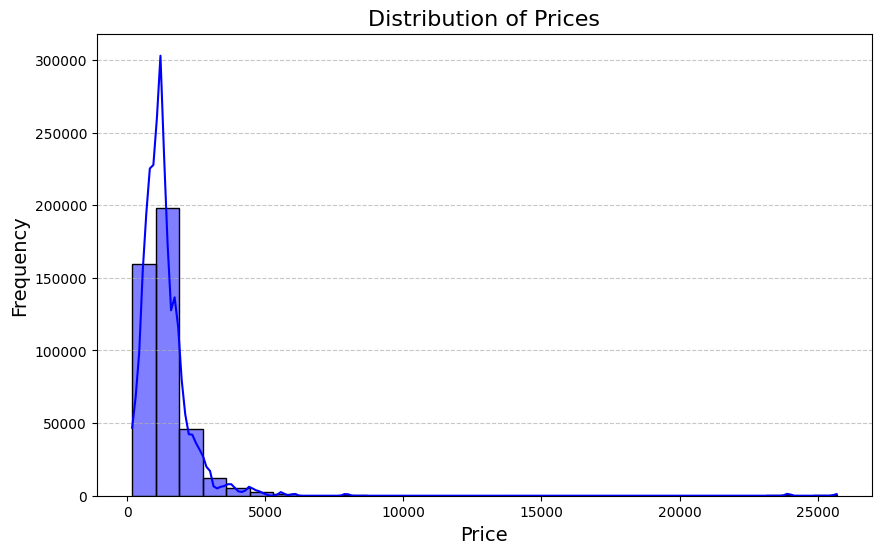

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=30, color='blue')
plt.title('Distribution of Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The distribution of the Price column shows **a right-skewed pattern**, with most prices concentrated near the lower end and a long tail extending toward higher values, indicating the presence of outliers representing extremely high prices. These outliers are not errors but rather valid data points that reflect real-world variations in pricing. Therefore, we will retain these outliers in the dataset to ensure the model captures the full range of price variability and reflects real-world trends accurately.

## <font color='navy'>**Data Preprocessing**</font>

We will convert all data to numeric

In [6]:
# Coverting the labels into a numeric form using Label Encoder
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype =='object':
        df[col] = le.fit_transform(df[col])


# storing the Dependent Variables in X and Independent Variable in Y
x = df.drop(['Price'],axis=1)
y = df['Price']

## <font color='navy'>**Split Data Into Training And Testing Sets**</font>

In [7]:
random_seed = 42
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30,random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((297634, 10), (127558, 10), (297634,), (127558,))

## <font color='navy'>**Scale The Values**</font>

In [8]:
mmscaler =MinMaxScaler(feature_range=(0,1))
x_train =mmscaler.fit_transform(x_train)
x_test =mmscaler.fit_transform(x_test)
x_train =pd.DataFrame(x_train)
x_test =pd.DataFrame(x_test)  

## <font color='navy'>**Model Evaluation Metrics Table**</font>

This table displays the performance metrics for various machine learning models, including error measures such as MAE, MSE, RMSE, and R² score, to facilitate comparison of their effectiveness.

In [9]:
a={'Model Name':[], 'Adj_R_Square':[], 'Mean_Absolute_Error_MAE':[] , 'Mean_Squared_Error_MSE':[] ,'Root_Mean_Squared_Error_RMSE':[] ,'Root_Mean_Squared_Log_Error_RMSLE':[] ,'Mean_Absolute_Percentage_Error_MAPE':[] ,'R2_score':[]}
Results=pd.DataFrame(a)
Results.head()

,Model Name,Adj_R_Square,Mean_Absolute_Error_MAE,Mean_Squared_Error_MSE,Root_Mean_Squared_Error_RMSE,Root_Mean_Squared_Log_Error_RMSLE,Mean_Absolute_Percentage_Error_MAPE,R2_score


## <font color='navy'>**Regression Models**</font>

### <font color='navy'>**Build The Baseline Model**</font>

In [10]:
# Initialize the KNeighborsRegressor with a specified number of neighbors
modelKNN = KNeighborsRegressor(n_neighbors=5)

# Fit the model with training data
modelKNN.fit(x_train, y_train)

# Predict the target values on the test data
y_pred_knn = modelKNN.predict(x_test)

# Print model name
print('Model Name: KNeighborsRegressor')

print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred_knn),3))  
print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred_knn),3))  
print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn)),3))
print('R2_score:', round(metrics.r2_score(y_test, y_pred_knn),6))
print('Root Mean Squared Log Error (RMSLE):', round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn))),3))

# Define the function to calculate MAPE (Mean Absolute Percentage Error)
def MAPE(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calculate MAPE
result_knn = MAPE(y_test, y_pred_knn)
print('Mean Absolute Percentage Error (MAPE):', round(result_knn, 2), '%')

# Calculate Adjusted R squared value
r_squared_knn = round(metrics.r2_score(y_test, y_pred_knn),6)
adjusted_r_squared_knn = round(1 - (1 - r_squared_knn) * (len(y_test) - 1) / (len(y_test) - x_train.shape[1] - 1), 6)
print('Adj R Square:', adjusted_r_squared_knn)

print('------------------------------------------------------------------------------------------------------------')

# Store the results in a new row
new_row_knn = {'Model Name' : 'KNeighborsRegressor',
               'Adj_R_Square' : adjusted_r_squared_knn,
               'Mean_Absolute_Error_MAE' : metrics.mean_absolute_error(y_test, y_pred_knn),
               'Mean_Squared_Error_MSE' : metrics.mean_squared_error(y_test, y_pred_knn),
               'Root_Mean_Squared_Error_RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn)),
               'Root_Mean_Squared_Log_Error_RMSLE' : np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn))),
               'Mean_Absolute_Percentage_Error_MAPE' : result_knn,
               'R2_score' : metrics.r2_score(y_test, y_pred_knn)}


Results = pd.concat([Results, pd.DataFrame([new_row_knn])], ignore_index=True)

Model Name: KNeighborsRegressor
Mean Absolute Error (MAE): 51.715
Mean Squared Error (MSE): 42293.73
Root Mean Squared Error (RMSE): 205.654
R2_score: 0.968684
Root Mean Squared Log Error (RMSLE): 5.326
Mean Absolute Percentage Error (MAPE): 3.73 %
Adj R Square: 0.968682
------------------------------------------------------------------------------------------------------------


Now that we have our baseline model (K-Neighbors Regressor), we’ll proceed with building and evaluating additional models, including <span style="color:navy"><b>Random Forest Regression</b></span>, <span style="color:navy"><b>Gradient Boosting</b></span>, <span style="color:navy"><b>Linear Regression</b></span>, <span style="color:navy"><b>Decision Tree Regressor</b></span>, <span style="color:navy"><b>Bagging Regressor</b></span>, <span style="color:navy"><b>Support Vector Regressor (SVR)</b></span>, <span style="color:navy"><b>XGBoost Regressor</b></span>, <span style="color:navy"><b>Extra Trees Regressor</b></span>, <span style="color:navy"><b>Ridge Regression</b></span>, and <span style="color:navy"><b>Lasso Regression</b></span>. These models will be trained on the same dataset, and we’ll evaluate their performance using several metrics to compare their effectiveness in predicting flight prices.


### <font color='navy'>**Build Predictive Models**</font>

In [11]:
# Initialize other regression models
modelmlg = LinearRegression()
modeldcr = DecisionTreeRegressor()
modelbag = BaggingRegressor()
modelrfr = RandomForestRegressor()
modelSVR = SVR()
modelXGR = xgb.XGBRegressor()
modelETR = ExtraTreesRegressor()
modelRE = Ridge()
modelLO = linear_model.Lasso(alpha=0.1)
modelGBR = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                     init=None, random_state=None, max_features=None,
                                     alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

# List of models to evaluate
## MM = [modelmlg, modeldcr, modelbag, modelrfr, modelETR, modelGBR, modelXGR, modelbag, modelRE, modelLO]
MM = [modelmlg, modeldcr, modelbag, modelrfr, modelETR, modelXGR, modelGBR, modelRE, modelLO]
# Evaluate all models in the list
for model in MM:
    
    # Fit the model with train data
    model.fit(x_train, y_train)
    
    # Predict the model with test data
    y_pred = model.predict(x_test)
    
    # Print the model name
    print('Model Name:', model)
    
    # Evaluation metrics for Regression analysis
    from sklearn import metrics

    print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred),3))  
    print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred),3))  
    print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
    print('R2_score:', round(metrics.r2_score(y_test, y_pred),6))
    print('Root Mean Squared Log Error (RMSLE):', round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),3))
    
    # Define the function to calculate MAPE - Mean Absolute Percentage Error
    def MAPE(y_test, y_pred):
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Evaluation of MAPE 
    result = MAPE(y_test, y_pred)
    print('Mean Absolute Percentage Error (MAPE):', round(result, 2), '%')
    
    # Calculate Adjusted R squared values 
    r_squared = round(metrics.r2_score(y_test, y_pred),6)
    adjusted_r_squared = round(1 - (1 - r_squared)*(len(y_test)-1)/(len(y_test)-x_train.shape[1]-1),6)
    print('Adj R Square:', adjusted_r_squared)
    print('------------------------------------------------------------------------------------------------------------')
    
    # Store the results in a new row
    new_row = {'Model Name' : model.__class__.__name__,
               'Adj_R_Square' : adjusted_r_squared,
               'Mean_Absolute_Error_MAE' : metrics.mean_absolute_error(y_test, y_pred),
               'Mean_Squared_Error_MSE' : metrics.mean_squared_error(y_test, y_pred),
               'Root_Mean_Squared_Error_RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
               'Root_Mean_Squared_Log_Error_RMSLE' : np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),
               'Mean_Absolute_Percentage_Error_MAPE' : result,
               'R2_score' : metrics.r2_score(y_test, y_pred)}

    # Append to Results DataFrame
    Results = pd.concat([Results, pd.DataFrame([new_row])], ignore_index=True)

Model Name: LinearRegression()
Mean Absolute Error (MAE): 580.906
Mean Squared Error (MSE): 1256833.463
Root Mean Squared Error (RMSE): 1121.086
R2_score: 0.069381
Root Mean Squared Log Error (RMSLE): 7.022
Mean Absolute Percentage Error (MAPE): 59.62 %
Adj R Square: 0.069308
------------------------------------------------------------------------------------------------------------
Model Name: DecisionTreeRegressor()
Mean Absolute Error (MAE): 49.971
Mean Squared Error (MSE): 54525.898
Root Mean Squared Error (RMSE): 233.508
R2_score: 0.959626
Root Mean Squared Log Error (RMSLE): 5.453
Mean Absolute Percentage Error (MAPE): 3.63 %
Adj R Square: 0.959623
------------------------------------------------------------------------------------------------------------
Model Name: BaggingRegressor()
Mean Absolute Error (MAE): 45.403
Mean Squared Error (MSE): 47577.252
Root Mean Squared Error (RMSE): 218.122
R2_score: 0.964772
Root Mean Squared Log Error (RMSLE): 5.385
Mean Absolute Percentage 

### <font color='navy'>**Table of Results for All Models**</font>

In [12]:
Results.sort_values(by='Adj_R_Square',ascending=False).reset_index(drop=True)

,Model Name,Adj_R_Square,Mean_Absolute_Error_MAE,Mean_Squared_Error_MSE,Root_Mean_Squared_Error_RMSE,Root_Mean_Squared_Log_Error_RMSLE,Mean_Absolute_Percentage_Error_MAPE,R2_score
0,XGBRegressor,0.976481,70.238624,3.176070e+04,178.215332,5.182993,5.906265,0.976483
1,KNeighborsRegressor,0.968682,51.715350,4.229373e+04,205.654395,5.326197,3.730668,0.968684
2,RandomForestRegressor,0.965352,45.190327,4.678898e+04,216.307606,5.376701,3.230082,0.965355
3,BaggingRegressor,0.964769,45.403402,4.757725e+04,218.122103,5.385055,3.236017,0.964772
4,ExtraTreesRegressor,0.960040,49.796465,5.396282e+04,232.298993,5.448025,3.614698,0.960043
5,DecisionTreeRegressor,0.959623,49.970843,5.452590e+04,233.507812,5.453216,3.628074,0.959626
6,GradientBoostingRegressor,0.873832,302.123552,1.703805e+05,412.771700,6.022895,27.327417,0.873842
7,Lasso,0.069350,580.716755,1.256776e+06,1121.060264,7.022030,59.590050,0.069423
8,LinearRegression,0.069308,580.905581,1.256833e+06,1121.085841,7.022053,59.615298,0.069381
9,Ridge,0.069308,580.900846,1.256832e+06,1121.085343,7.022053,59.614715,0.069381


### <font color='navy'>**Compare Models**</font>

Based on the results above, the <font color='black'>**top 3 models**</font>, ranked by their performance in terms of Errors, Adjusted R-Square, and R2 Score, are: <br>
**1-** <font color='pink'>**XGBRegresso**</font> <br>
**2-** <font color='purple'>**KNeighborsRegressor**</font> <br>
**3-** <font color='lightblue'>**RandomForestRegressor**</font> <br><br>

## <font color='navy'>**Visualizing The Results**</font>

## <font color='pink'>**XGBRegressor**</font>

### <font color='navy'>**Actual VS Predicted**</font>

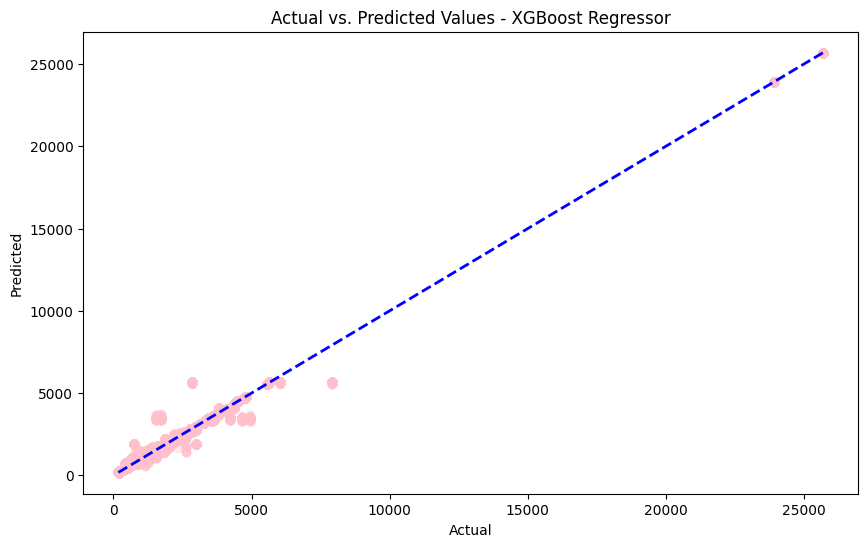

In [34]:
# Predict using the XGBoost model
y_pred_xgb = modelXGR.predict(x_test)

# Plot=
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='pink')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values - XGBoost Regressor')
plt.show()

This plot shows the relationship between the actual and the predicted values XGBoost. The scatter points represent the predicted flight prices plotted against the actual prices from the test set. If the model were perfect, all points would lie along the blue dashed line, which represents the ideal scenario where predicted equals actual. This plot helps to visually assess how well the model is performing:

A **closer** fit to the blue line indicates better performance, meaning the predictions are more accurate.
**Larger deviations** from the line indicate that the model's predictions are **less accurate.**

From the graph, we can see that the points are close to the line, which indicates that the preformance is good.

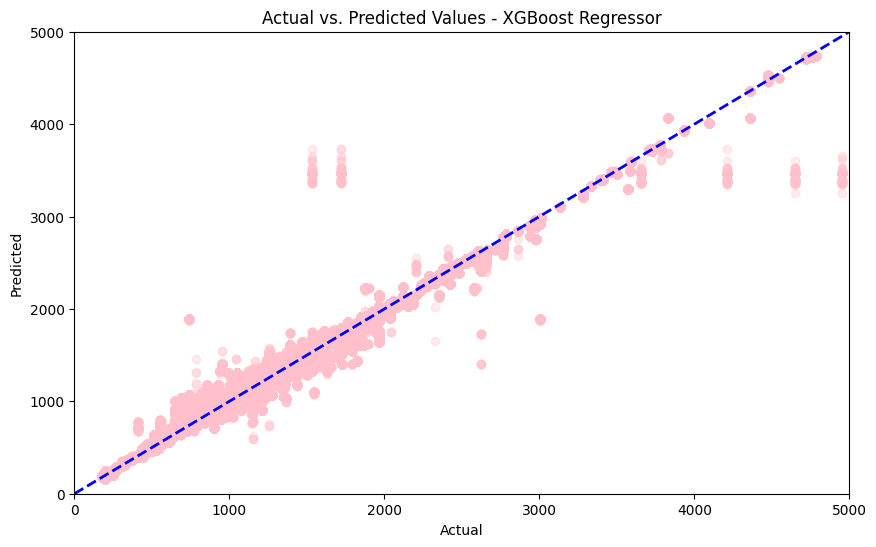

In [37]:
# Define a manual upper limit for filtering outliers
upper_limit = 5000  # Adjusted threshold based on outlier analysis

# Filter the data to exclude rows where actual or predicted values exceed the upper limit
filtered_indices_xgb = (y_test <= upper_limit) & (y_pred_xgb <= upper_limit)

y_test_filtered_xgb = y_test[filtered_indices_xgb]
y_pred_filtered_xgb = y_pred_xgb[filtered_indices_xgb]

# Plot the filtered data with adjusted zoom
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered_xgb, y_pred_filtered_xgb, alpha=0.3, color='pink')
plt.plot([0, upper_limit], [0, upper_limit], 'b--', lw=2)  # Adjust diagonal line to the new zoom level
plt.xlim(0, upper_limit)  # Set x-axis limit
plt.ylim(0, upper_limit)  # Set y-axis limit
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values - XGBoost Regressor')
plt.show()

### <font color='navy'>**Residuals Plot**</font>

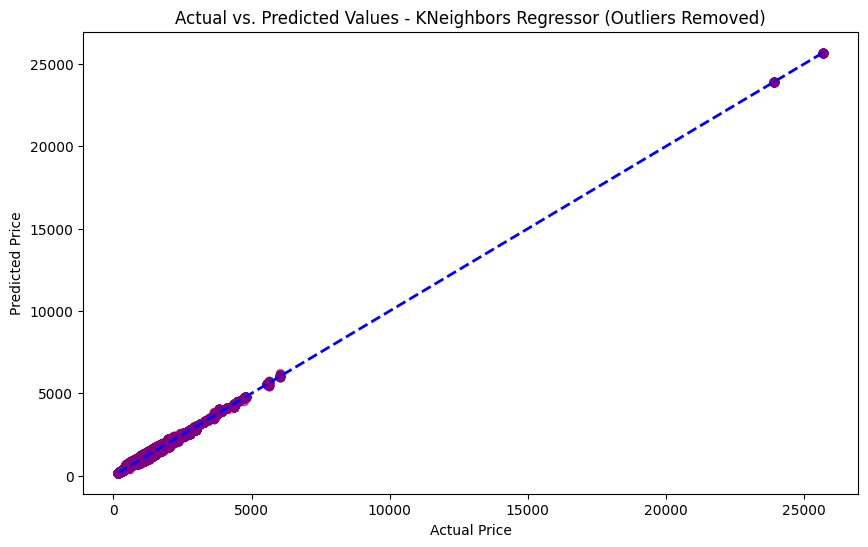

In [ ]:
# Calculate residuals for the XGBoost model
residuals_xgb = y_test - y_pred_xgb

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.3, color='pink')
plt.hlines(0, xmin=y_pred_xgb.min(), xmax=y_pred_xgb.max(), linestyles='dashed', colors='blue')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted - XGBoost Regressor')
plt.show()

The residuals plot shows the residuals (the differences between the actual and predicted values) on the y-axis and the predicted values on the x-axis. The residuals represent the errors made by the model:

- From the graph, we see that there's some spread in residuals, particurally for lower predicted values, indicating that the model has larger errors in this range.
- The residual appear to decrease and approach zero as predicted prices increase, suggesting the model performs bettwer with higher-priced predictions.

## <font color='purple'>**KNeighbors Regressor**</font>

### <font color='navy'>**Actual VS Predicted**</font>

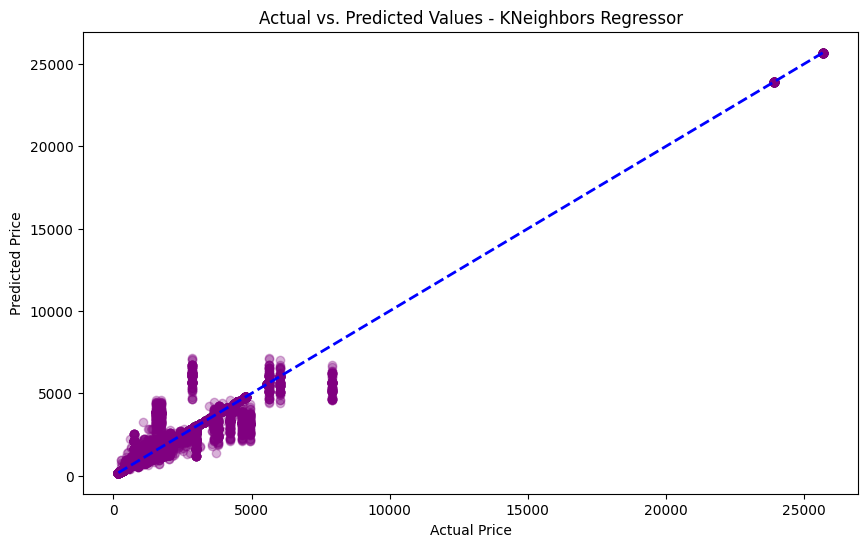

In [15]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Values - KNeighbors Regressor')
plt.show()

From the plot, we observe that the majority of the points align closely with the blue line, indicating good performance by the model. However, some scattered deviations at higher price ranges suggest that the model may struggle slightly with predictions for higher flight prices. Overall, the model demonstrates reasonable accuracy in predicting flight prices.

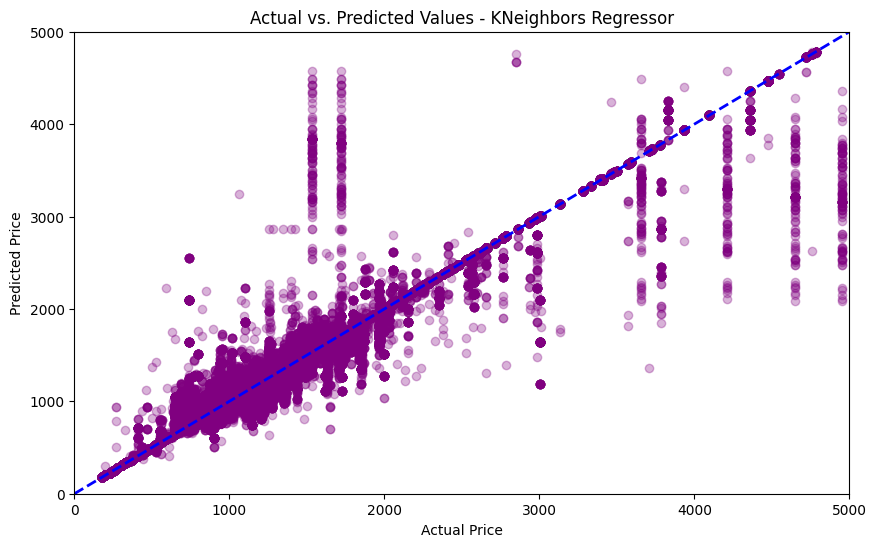

In [38]:
# Define the upper limit for focusing on non-outlier data
upper_limit_knn = 5000  # Adjust based on outlier analysis

# Filter the data for KNeighbors Regressor
filtered_indices_knn = (y_test <= upper_limit_knn) & (y_pred_knn <= upper_limit_knn)

y_test_filtered_knn = y_test[filtered_indices_knn]
y_pred_filtered_knn = y_pred_knn[filtered_indices_knn]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered_knn, y_pred_filtered_knn, alpha=0.3, color='purple')
plt.plot([0, upper_limit_knn], [0, upper_limit_knn], 'b--', lw=2)  # Adjust diagonal line
plt.xlim(0, upper_limit_knn)  # Set x-axis limit
plt.ylim(0, upper_limit_knn)  # Set y-axis limit
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Values - KNeighbors Regressor')
plt.show()

### <font color='navy'>**Residuals Plot**</font>

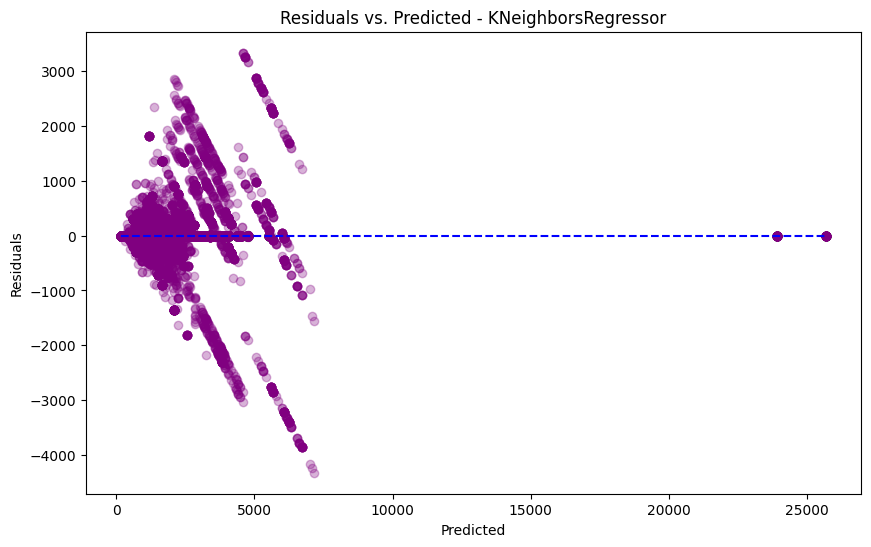

In [16]:
# Calculate residuals for the KNeighbors Regressor model
residuals_knn = y_test - y_pred_knn

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_knn, residuals_knn, alpha=0.3, color='purple')
plt.hlines(0, xmin=y_pred_knn.min(), xmax=y_pred_knn.max(), linestyles='dashed', colors='blue')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted - KNeighborsRegressor')
plt.show()

From the graph:

- The residuals are relatively clustered around zero for lower price ranges, indicating good model performance for cheaper flights. <br><br>
- For higher predicted values, residuals tend to spread more, showing that the model may struggle with accuracy for more expensive flights. <br><br>
- No clear pattern or curvature is visible, which is a good sign, as it suggests the model's errors are randomly distributed and there is no systematic bias in predictions. <br><br>
Overall, the residuals plot highlights that the KNeighborsRegressor performs well for the majority of predictions, though further improvements may be needed for more expensive flights.

## <font color='lightblue'>**Random Forest Regressor**</font>

### <font color='navy'>**Actual VS Predicted**</font>

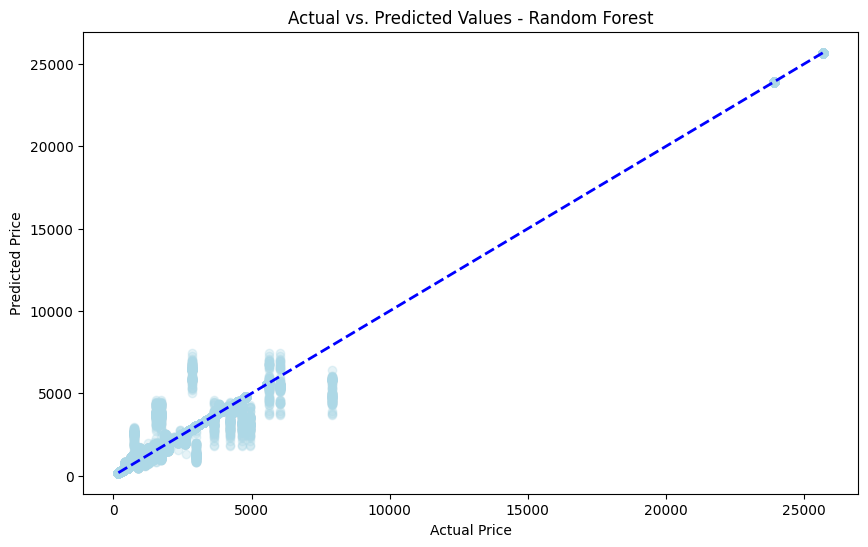

In [17]:
# Make predictions using the Random Forest model
y_pred_rf = modelrfr.predict(x_test)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='lightblue')  
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2)  
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Values - Random Forest')
plt.show()

From the plot, it's evident that the Random Forest model demonstrates strong predictive accuracy, as the predicted fares closely align with the actual fares across the price spectrum. The alignment of points along the diagonal line highlights its reliability in handling flight fare prediction, even for higher-value tickets.

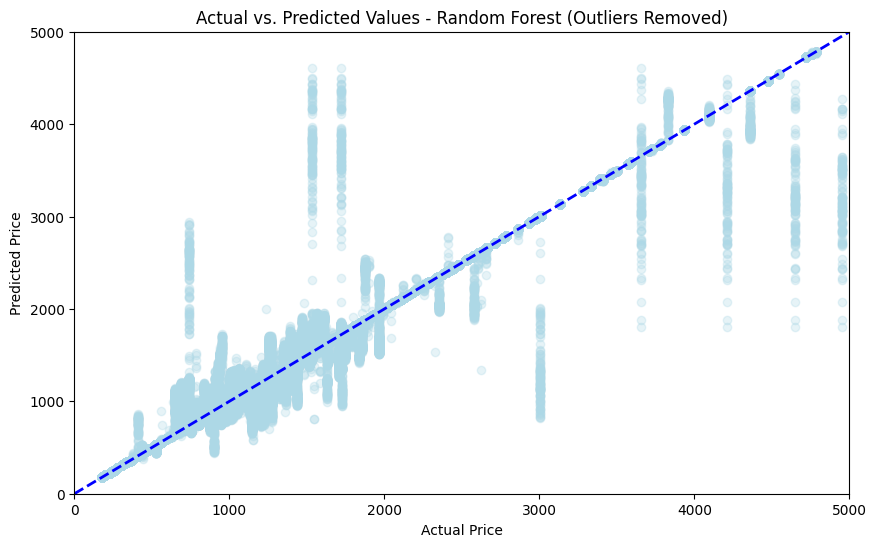

In [ ]:
# Define the upper limit for focusing on non-outlier data
upper_limit_rf = 5000  # Adjust based on outlier analysis

# Filter the data for Random Forest Regressor
filtered_indices_rf = (y_test <= upper_limit_rf) & (y_pred_rf <= upper_limit_rf)

y_test_filtered_rf = y_test[filtered_indices_rf]
y_pred_filtered_rf = y_pred_rf[filtered_indices_rf]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered_rf, y_pred_filtered_rf, alpha=0.3, color='lightblue')
plt.plot([0, upper_limit_rf], [0, upper_limit_rf], 'b--', lw=2)  # Adjust diagonal line
plt.xlim(0, upper_limit_rf)  # Set x-axis limit
plt.ylim(0, upper_limit_rf)  # Set y-axis limit
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Values - Random Forest')
plt.show()

### <font color='navy'>**Residuals Plot**</font>

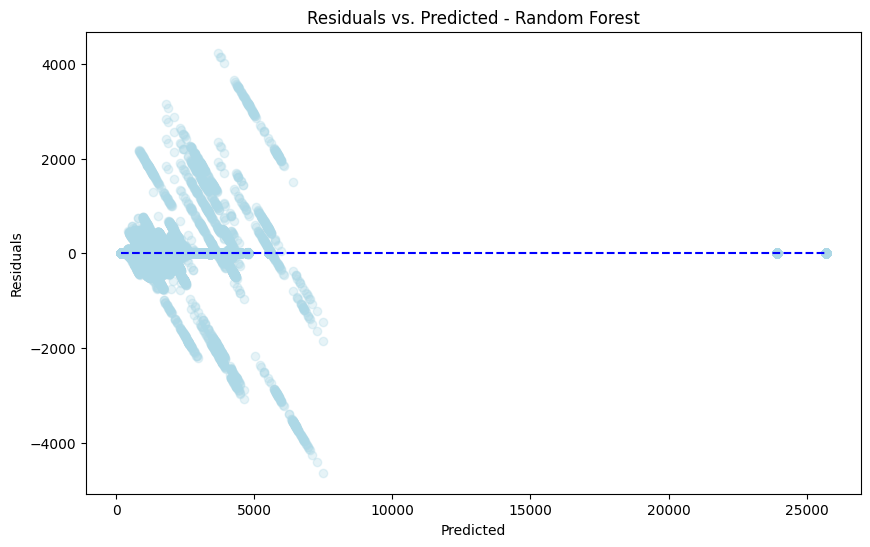

In [18]:
# Calculate residuals for the Random Forest model
residuals_rfr = y_test - y_pred_rf

# Plot: Residuals vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals_rfr, alpha=0.3, color='lightblue')
plt.hlines(0, xmin=y_pred_rf.min(), xmax=y_pred_rf.max(), linestyles='dashed', colors='blue')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted - Random Forest')
plt.show()

The residual plot shows the differences between actual and predicted flight fares using the Random Forest model, with residuals plotted against predicted fares. Most of the points are close to the zero line, which means the model is doing a good job of predicting the fares for most cases. The spread of residuals looks even, and there isn’t any obvious pattern, so the model doesn’t seem to have any big bias. Also, the residuals are consistent across different predicted fare values, which is a good sign for accuracy. There are a few outliers, though, especially for lower predicted fares, where the difference goes beyond ±4,000. These could be special cases where the model didn’t predict as well. Overall, the plot shows that the model is reliable and accurate, with only a few small errors.

### <font color='navy'>**Conclusion**</font>

The regression analysis successfully identified the XGBoost model as the most accurate and reliable predictor of flight prices among the tested models. With its high R² score and low error metrics, XGBoost demonstrated its ability to capture complex patterns in the data, outperforming other techniques such as Random Forest, Gradient Boosting, and K-Nearest Neighbors.

While most models performed well on lower-priced flights, some struggled with higher-priced outliers, highlighting areas for potential improvement. The comprehensive evaluation using metrics like MAE, MSE, RMSE, and Adjusted R² provided valuable insights into each model's strengths and limitations.

Overall, the regression models laid a strong foundation for predicting flight prices and provided a benchmark for future enhancements, setting the stage for further insights through clustering analysis.

# -----------------------------------------------------------------------------

## <font color='navy'>**Clustering**</font>

In [19]:
df_clustering = df.copy()

### <font color='navy'>**Removing Unnecessary Columns**</font>
Features like  **Flight lands next day** and **Price** might not provide meaningful clustering signals. So we decided to drop them.

In [20]:
df_clustering = df_clustering.drop(['Price', 'Flight Lands Next Day'], axis=1)

### <font color='navy'>**Standardizing The Data**</font>

In [21]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_clustering)

x_scaled_df = pd.DataFrame(x_scaled, columns=df_clustering.columns)

Clustering algorithms like K-Means are sensitive to scale, so we first need to standardize the data. This step ensures that features with larger ranges (flight duration, price) don’t dominate the clustering process.

### <font color='navy'>**Using One-Hot Encoding**</font>

In [22]:
df_clustering = pd.get_dummies(df_clustering, drop_first=True)

### <font color='navy'>**Dimensionality Reduction**</font>
Since we have many features, we use PCA to reduce the dimensionality of the dataset. This helps to focus on the most informative components, which can improve clustering performance by eliminating noise and reducing computation time without losing significant information.

In [23]:
pca = PCA(n_components=0.9)
x_pca = pca.fit_transform(x_scaled)
print(f"Explained variance by PCA components: {pca.explained_variance_ratio_}")

Explained variance by PCA components: [0.22150989 0.19974585 0.15095988 0.13320078 0.11442697 0.09058421]


0.22150989 + 0.19974585 + 0.15095988+0.13320078 + 0.11442697+0.09058421 = 91.0% <br>
This means the first 6 principal components capture 91% of the total variance in our data, which indicates that the majority of the information in the dataset is preserved after dimensionality reduction.

### <font color='navy'>**Taking  A Random Sample From The Dataset**</font>
A random sample is used because the dataset is very large, and processing the entire dataset would be computationally expensive and time-consuming. By reducing the dataset size, we can efficiently perform clustering and other analyses while maintaining representative insights.

In [24]:
x_pca_sample = resample(x_pca, n_samples=5000, random_state=42)

### <font color='navy'>**K-Means**</font>

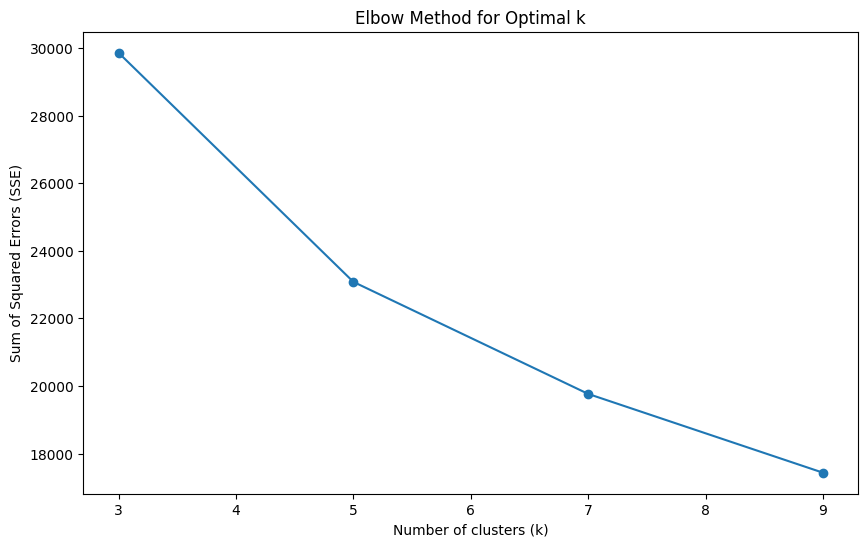

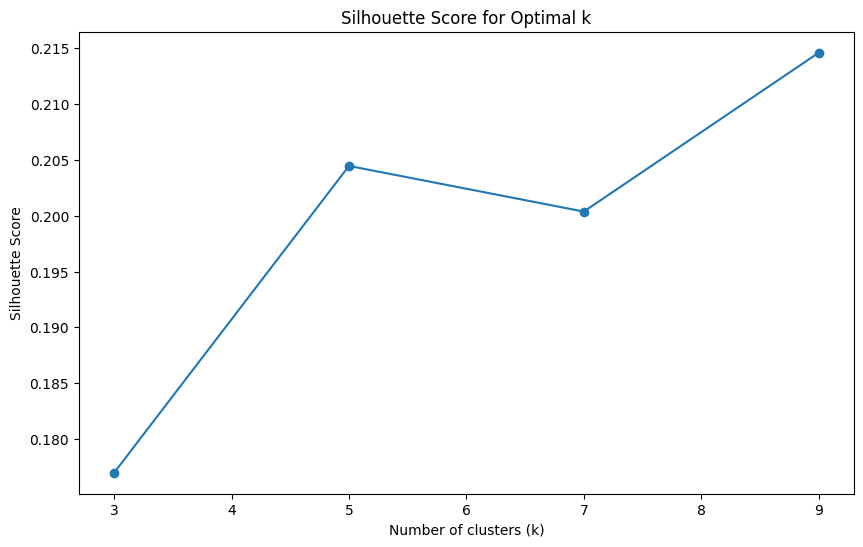

In [25]:
sse = []
silhouette_scores = []
k_values = [3, 5, 7, 9]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=1, init='k-means++')
    kmeans.fit(x_pca_sample)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(x_pca_sample, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

<font color='navy'>**The Elbow Method:**</font> <br>
The Elbow Method plot illustrates the Sum of Squared Errors (SSE) for different numbers of clusters (k). The SSE decreases as k increases, indicating better fit to the data. However, beyond k = 5, the rate of decrease slows down significantly, forming an "elbow." This suggests that k = 5 is the optimal number of clusters, as increasing k further provides diminishing returns in reducing the SSE. <br><br>

<font color='navy'>**Silhouette Score:**</font> <br>
The Silhouette Score plot measures the cohesion and separation of clusters for different values of k. The silhouette score is highest at k = 9 (0.215), indicating that this is the optimal number of clusters, as the clustering structure is most cohesive and well-separated. The score starts low at k = 3 (around 0.18) and improves significantly at k = 5 (0.205), showing better-defined clusters. However, the score slightly declines at k = 6 and k = 7 before steadily increasing again, peaking at k = 9.

<font color='gray'>**The silhouette method shows that k = 9 gives the best-defined clusters, while the elbow method suggests k = 5 as the best option because it balances cluster quality and simplicity. Choosing the best k depends on what’s more important for the analysis. If the goal is to get the best clustering quality, k = 9 might be better, but if simplicity and easier interpretation are more important, k = 5 could be a good choice.**</font>

### <font color='navy'>**Gaussian Mixture Models (GMM)**</font>

In [26]:
# Fit a GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(x_pca_sample)

# Evaluate with silhouette score
gmm_silhouette = silhouette_score(x_pca_sample, gmm_labels)
print(f'Silhouette Score for GMM: {gmm_silhouette}')

Silhouette Score for GMM: 0.17349005903830833


### <font color='navy'>**DBSCAN**</font>

In [27]:
# Fit DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(x_pca_sample)

# Evaluate clusters
dbscan_silhouette = silhouette_score(x_pca_sample, dbscan_labels)
print(f'Silhouette Score for DBSCAN: {dbscan_silhouette}')

Silhouette Score for DBSCAN: -0.35675557381758743


### <font color='navy'>**Hierarchical Clustering**</font>

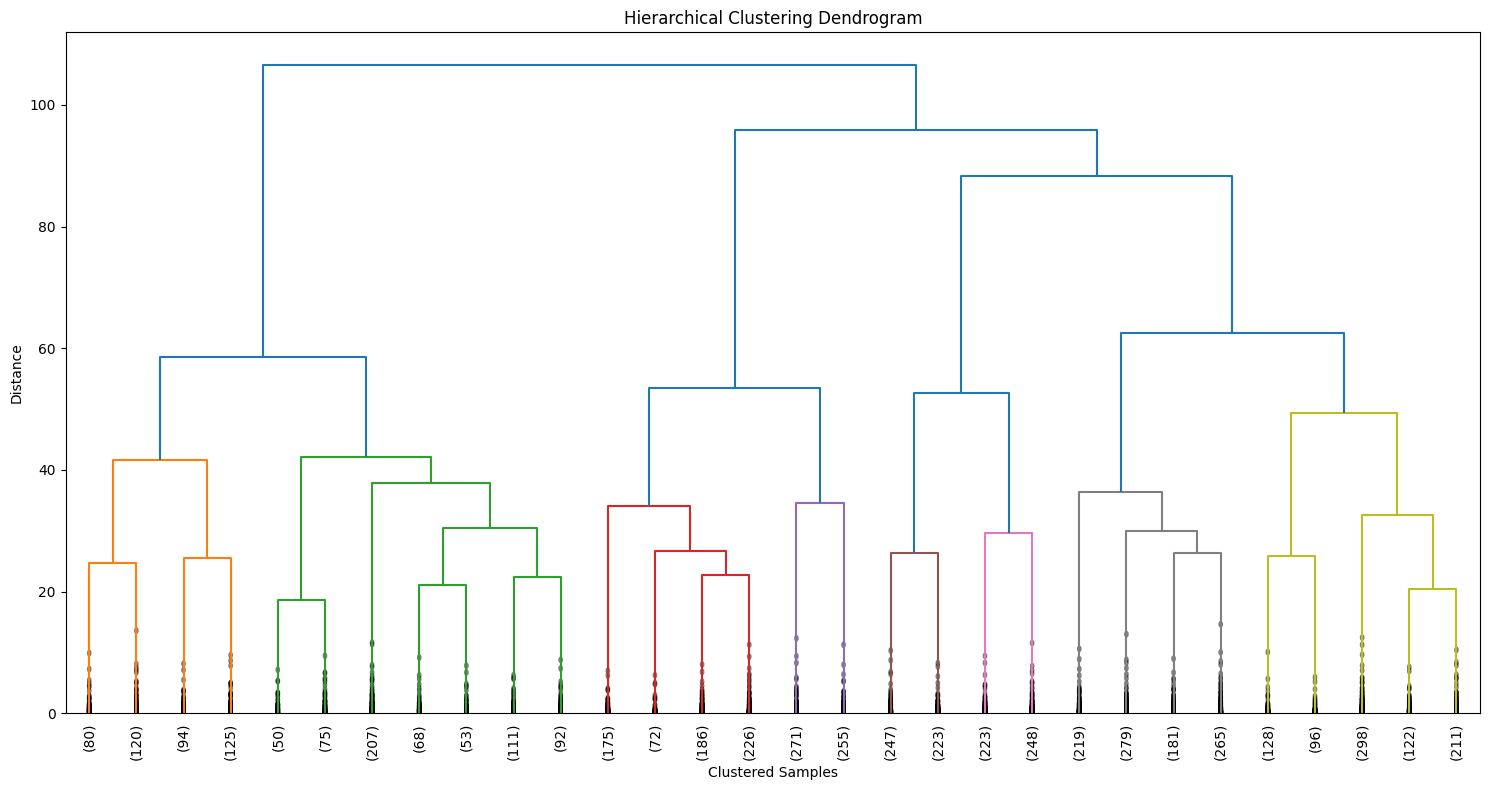

In [28]:
linkage_matrix = linkage(x_pca_sample, method='ward')

# Plot dendrogram with focus on lower part to be CLEAR
plt.figure(figsize=(15, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Show only the last `p` merges which is 30
    p=30,  # The number of clusters to display
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=50,
    show_contracted=True
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Clustered Samples')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

The dendrogram shows how data points are hierarchically grouped based on similarity. At lower distances, smaller clusters merge (e.g., samples like 80 and 120), while at higher distances, larger, distinct clusters are formed. Cutting the dendrogram around a height of 50 suggests 4–5 main clusters. The wide separation at higher levels indicates well-defined groupings in the data.

### <font color='navy'>**Conclusion**</font>

<font color='navy'>**K-Means:**</font> <br>
- **Silhouette Score:** 0.215, The Silhouette Score for K-Means peaks at 0.215 when k=9, indicating that the clusters are moderately well-defined. This score reflects a decent balance between intra-cluster cohesion and inter-cluster separation. While the clustering is not perfect, it is notably better than the other methods.<br><br>

<font color='navy'>**Gaussian Mixture Models (GMM):**</font> <br>
- **Silhouette Score:** 0.173, A Silhouette Score of 0.173 indicates that the clustering quality is not very strong. The score suggests that while some separation exists between the clusters, there is still a significant overlap or uncertainty in cluster assignment. A score closer to 1 would indicate well-separated clusters, so further tuning or feature engineering might be required to improve clustering performance. <br><br>

<font color='navy'>**DBSCAN:**</font> <br>
- **Silhouette Score:** -0.357, A Silhouette Score of -0.357 strongly suggests that DBSCAN is unsuitable for this dataset, likely due to its sensitivity to parameter tuning or the underlying structure of the data, which might not fit the density-based clustering assumptions. <br><br>


<font color='gray'>**In conclusion, K-Means is the best method for this dataset, achieving the highest Silhouette Score (0.215) and forming well-defined clusters. GMM (0.173) showed moderate performance, while DBSCAN performed poorly with negative Silhouette Scores, indicating its unsuitability for this data.**</font>


# -----------------------------------------------------------------------------

## <font color='navy'>**Final Conclusion**</font>

#### This project successfully developed an advanced flight price prediction model and performed in-depth clustering analysis to uncover meaningful patterns in the data. By starting with a baseline K-Nearest Neighbors model and systematically evaluating multiple regression techniques—including Random Forest, Gradient Boosting, and XGBoost—we identified XGBoost as the best-performing model. Its high R² score, low error metrics, and robust handling of data complexities make it a highly accurate and reliable choice for predicting flight prices.

#### Clustering analysis, supported by PCA for dimensionality reduction, identified K-Means as the most effective algorithm, achieving the highest silhouette score and forming well-defined clusters. These clusters offer valuable insights into pricing tiers and traveler behavior. By retaining outliers and applying thoughtful preprocessing, the project captured the full variability of flight prices, ensuring realistic and actionable predictions.

#### The project excels in combining machine learning and clustering techniques with domain-driven insights, delivering a solution that is both practical and scalable. Future work could explore advanced feature engineering, hyperparameter tuning, and further interpretation of clusters to enhance the model’s precision and broaden its applications. This comprehensive approach demonstrates a deep understanding of data science principles and highlights the potential for impactful real-world applications.